### Load Required Libraries here

In [1]:
import os
import numpy as np
np.random.seed(111)
import pandas as pd
from keras import layers
from keras import models
from keras import metrics
from keras import optimizers
from keras import callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
import matplotlib.pyplot as plot
from sklearn import model_selection
from sklearn import preprocessing

Using TensorFlow backend.


##  Read Train & Test Data and replace NA values

In [2]:
path = os.getcwd()
os.listdir()

['.ipynb_checkpoints',
 'AttributeDescription.pdf',
 'CUTe_CSE7321c_Batch39_Group_2.pptx',
 'CUTe_CSE7321c_Batch39_Group_2.zip',
 'Document Classification With One Hot Encoding.ipynb',
 'Document Classification With Pre-Trained Embedding.ipynb',
 'Document Classification With Word Embedding.ipynb',
 'test.csv',
 'train.csv',
 '~$CUTe_CSE7321c_Batch39_Group_2.pptx']

In [3]:
train = pd.read_csv("train.csv", index_col = "ID", na_values=" ")
test = pd.read_csv("test.csv", na_values=" ")

In [4]:
train[train.isnull().any(axis=1)]
test[test.isnull().any(axis=1)]

,ID,converse
2811,14194,NaN
3603,18173,NaN
4447,22293,NaN
6261,31275,NaN
6737,33762,NaN
9539,47537,NaN
9702,48370,NaN


In [5]:
# replacing na values with string blank"
#train = train.replace(np.nan,"Balnk")
#test = test.replace(np.nan, "Blank")

train.fillna("Blank", inplace=True)
test.fillna("Blank", inplace=True)

## Tokenize & vectorize data using word embeddings 

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['converse'])
word_index = tokenizer.word_index

In [7]:
max_words = len(word_index) + 1
print("unique words ",max_words)
embedding_dim = 100
max_len = 150

unique words  34770


### Label Encoder

In [8]:
# labels counts before encoding
train['categories'].value_counts()

PRESCRIPTION     12077
APPOINTMENTS     11098
MISCELLANEOUS     9736
ASK_A_DOCTOR      9440
LAB               3457
JUNK                17
Name: categories, dtype: int64

In [9]:
label_encoder = preprocessing.LabelEncoder()
labels_encoded = label_encoder.fit_transform(train['categories'])

In [10]:
# Label Counts after encoding
pd.Series(labels_encoded).value_counts()

5    12077
0    11098
4     9736
1     9440
3     3457
2       17
dtype: int64

In [11]:
def vectorize_text_data(tokenizer, data, word_len=max_len):
    text_to_seq = tokenizer.texts_to_sequences(data)
    return pad_sequences(text_to_seq, word_len)
  
def create_test_submission_file(test_preds, fileName):
    preds_decoded = label_encoder.inverse_transform(test_preds)
    test_data = {'ID' : test['ID'], 'categories' : preds_decoded}
    output = pd.DataFrame(data=test_data, columns=['ID','categories'])
    output.to_csv(fileName,index=False)

def plotTrainValidationAccuracy(model_history, name):
    plot.clf()
    history_dict = model_history.history
    train_acc = history_dict["acc"]
    val_acc = history_dict["val_acc"]
    epocs = range(1, len(train_acc) + 1)
    plot.plot(epocs, train_acc, "go", label = "Training Accuracy")
    plot.plot(epocs, val_acc, "g", label = "Validation Accuracy")
    plot.title(name + " Training & validation accuracy")
    plot.xlabel("Epocs")
    plot.ylabel("Accuracy")
    plot.legend()
    plot.show()      

### Prepare Train & Validation data 
### split of data 85:15
### Vectorizing text data

In [12]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(train['converse'], labels_encoded, random_state = 111, 
                                                                  stratify = labels_encoded, test_size = 0.15)
x_train = vectorize_text_data(tokenizer, x_train)
x_val = vectorize_text_data(tokenizer, x_val)
x_test = vectorize_text_data(tokenizer, test['converse'])
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)

(38951, 150)
(38951, 6)
(6874, 150)
(6874, 6)
(11455, 150)


# Build Models for Document Classification into 6 Categories

### 1. Build a MLP network

In [14]:
len_categories = len(np.unique(labels_encoded))

In [15]:
mlpNetwork = models.Sequential()
mlpNetwork.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
mlpNetwork.add(layers.Flatten())
mlpNetwork.add(layers.Dense(len_categories, activation="softmax"))
mlpNetwork.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          3477000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 90006     
Total params: 3,567,006
Trainable params: 3,567,006
Non-trainable params: 0
_________________________________________________________________


Train on 38951 samples, validate on 6874 samples
Epoch 1/5
38951/38951 [==============================] - 68s 2ms/step - loss: 0.7563 - acc: 0.7201 - val_loss: 0.6221 - val_acc: 0.7784
Epoch 2/5
38951/38951 [==============================] - 58s 1ms/step - loss: 0.5107 - acc: 0.8172 - val_loss: 0.6384 - val_acc: 0.7731
Epoch 3/5
38951/38951 [==============================] - 59s 2ms/step - loss: 0.3616 - acc: 0.8766 - val_loss: 0.7188 - val_acc: 0.7573
Epoch 4/5
38951/38951 [==============================] - 56s 1ms/step - loss: 0.2370 - acc: 0.9251 - val_loss: 0.7869 - val_acc: 0.7571


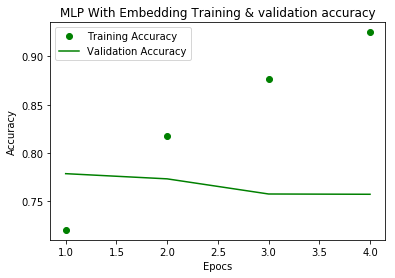

11455/11455 [==============================] - 1s 75us/step


In [16]:
modelName = 'best_mlp_embedded_model.h5'
call_backs = [callbacks.EarlyStopping(monitor='val_acc', patience=3),
             callbacks.ModelCheckpoint(filepath=modelName, monitor='val_acc', save_best_only=True)]
mlpNetwork.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
mlpNetworkHistory = mlpNetwork.fit(x_train, y_train, epochs=5, callbacks=call_backs, validation_data=(x_val,y_val))
plotTrainValidationAccuracy(model_history=mlpNetworkHistory, name="MLP With Embedding")
best_model = models.load_model(modelName)
create_test_submission_file(best_model.predict_classes(x_test),  "test_mlp_embedded_model.csv")

### 2. Build Simple RNN Network

In [17]:
simpleRnnNetwork = models.Sequential()
simpleRnnNetwork.add(layers.Embedding(max_words, embedding_dim))
simpleRnnNetwork.add(layers.SpatialDropout1D(0.3))
simpleRnnNetwork.add(layers.SimpleRNN(64))
simpleRnnNetwork.add(layers.Dense(64, activation="relu"))
simpleRnnNetwork.add(layers.Dropout(0.25))
simpleRnnNetwork.add(layers.Dense(len_categories, activation="softmax"))
simpleRnnNetwork.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         3477000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 100)         0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                10560     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 3,492,110
Trainable params: 3,492,110
Non-trainable params: 0
_________________________________________________________________


Train on 38951 samples, validate on 6874 samples
Epoch 1/5
38951/38951 [==============================] - 124s 3ms/step - loss: 1.1260 - acc: 0.5544 - val_loss: 0.9042 - val_acc: 0.6670
Epoch 2/5
38951/38951 [==============================] - 118s 3ms/step - loss: 0.9261 - acc: 0.6602 - val_loss: 0.8704 - val_acc: 0.6949
Epoch 3/5
38951/38951 [==============================] - 125s 3ms/step - loss: 0.8710 - acc: 0.6976 - val_loss: 0.8087 - val_acc: 0.7208
Epoch 4/5
38951/38951 [==============================] - 116s 3ms/step - loss: 0.9108 - acc: 0.6651 - val_loss: 0.8376 - val_acc: 0.6989
Epoch 5/5
38951/38951 [==============================] - 135s 3ms/step - loss: 0.8336 - acc: 0.7069 - val_loss: 0.7742 - val_acc: 0.7405


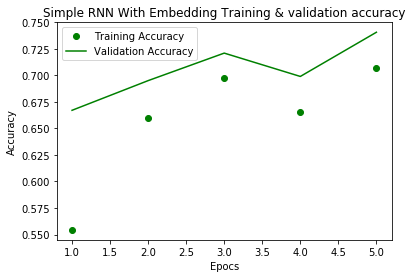

11455/11455 [==============================] - 11s 927us/step


In [18]:
modelName = 'best_simple_RNN_embedded_model.h5'
call_backs = [callbacks.EarlyStopping(monitor='val_acc', patience=3),
             callbacks.ModelCheckpoint(filepath=modelName, monitor='val_acc', save_best_only=True)]
simpleRnnNetwork.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
simpleRnnNetworkHistory = simpleRnnNetwork.fit(x_train, y_train, epochs=5, callbacks=call_backs, validation_data=(x_val,y_val))
plotTrainValidationAccuracy(model_history=simpleRnnNetworkHistory, name="Simple RNN With Embedding")
best_model = models.load_model(modelName)
create_test_submission_file(best_model.predict_classes(x_test),  "test_simple_RNN_embedded_model.csv")

### 3. Build CNN 1D Network

In [20]:
cnnNetwork = models.Sequential()
cnnNetwork.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
cnnNetwork.add(layers.Conv1D(64, 5, activation='relu'))
cnnNetwork.add(layers.MaxPooling1D(4))
cnnNetwork.add(layers.Conv1D(64, 5, activation='relu'))
cnnNetwork.add(layers.MaxPooling1D(4))
cnnNetwork.add(layers.Flatten())
cnnNetwork.add(layers.Dense(64, activation = "relu"))
cnnNetwork.add(layers.Dense(len_categories, activation="softmax"))
cnnNetwork.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 100)          3477000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
__________

Train on 38951 samples, validate on 6874 samples
Epoch 1/5
38951/38951 [==============================] - 182s 5ms/step - loss: 0.7358 - acc: 0.7240 - val_loss: 0.5675 - val_acc: 0.7934
Epoch 2/5
38951/38951 [==============================] - 136s 3ms/step - loss: 0.4695 - acc: 0.8279 - val_loss: 0.5537 - val_acc: 0.7987
Epoch 3/5
38951/38951 [==============================] - 133s 3ms/step - loss: 0.3531 - acc: 0.8727 - val_loss: 0.5943 - val_acc: 0.7902
Epoch 4/5
38951/38951 [==============================] - 134s 3ms/step - loss: 0.2422 - acc: 0.9127 - val_loss: 0.7125 - val_acc: 0.7815
Epoch 5/5
38951/38951 [==============================] - 141s 4ms/step - loss: 0.1540 - acc: 0.9456 - val_loss: 0.9646 - val_acc: 0.7728


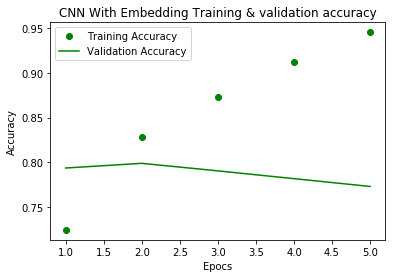

11455/11455 [==============================] - 7s 646us/step


In [21]:
modelName = 'best_cnn_embedded_model.h5'
call_backs = [callbacks.EarlyStopping(monitor='val_acc', patience=3),
             callbacks.ModelCheckpoint(filepath=modelName, monitor='val_acc', save_best_only=True)]
cnnNetwork.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
cnnNetworkHistory = cnnNetwork.fit(x_train, y_train, epochs=5, callbacks=call_backs, validation_data=(x_val,y_val))
plotTrainValidationAccuracy(model_history=cnnNetworkHistory, name="CNN With Embedding")
best_model = models.load_model(modelName)
create_test_submission_file(best_model.predict_classes(x_test),  "test_cnn_embedded_model.csv")

### 4. Build LSTM Model

In [22]:
lstmNetwork = models.Sequential()
lstmNetwork.add(layers.Embedding(max_words, embedding_dim))
lstmNetwork.add(layers.SpatialDropout1D(0.3))
lstmNetwork.add(layers.LSTM(100))
lstmNetwork.add(layers.Dense(64, activation = "relu"))
lstmNetwork.add(layers.Dropout(0.25))
lstmNetwork.add(layers.Dense(len_categories, activation="softmax"))
lstmNetwork.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         3477000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 3,564,254
Trainable params: 3,564,254
Non-trainable params: 0
_________________________________________________________________


Train on 38951 samples, validate on 6874 samples
Epoch 1/5
38951/38951 [==============================] - 279s 7ms/step - loss: 1.0091 - acc: 0.6237 - val_loss: 0.8833 - val_acc: 0.6874
Epoch 2/5
38951/38951 [==============================] - 279s 7ms/step - loss: 0.7260 - acc: 0.7516 - val_loss: 0.6608 - val_acc: 0.7635
Epoch 3/5
38951/38951 [==============================] - 279s 7ms/step - loss: 0.5884 - acc: 0.7949 - val_loss: 0.5845 - val_acc: 0.7843
Epoch 4/5
38951/38951 [==============================] - 283s 7ms/step - loss: 0.5201 - acc: 0.8198 - val_loss: 0.5765 - val_acc: 0.7991
Epoch 5/5
38951/38951 [==============================] - 474s 12ms/step - loss: 0.4616 - acc: 0.8390 - val_loss: 0.5707 - val_acc: 0.7946


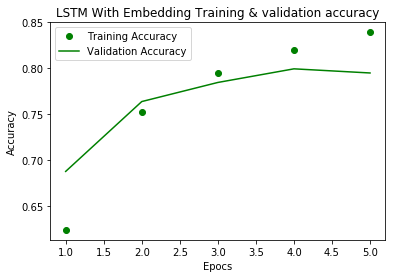

11455/11455 [==============================] - 21s 2ms/step


In [23]:
modelName = 'best_lstm_embedded_model.h5'
call_backs = [callbacks.EarlyStopping(monitor='val_acc', patience=3),
             callbacks.ModelCheckpoint(filepath=modelName, monitor='val_acc', save_best_only=True)]
lstmNetwork.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
lstmNetworkHistory = lstmNetwork.fit(x_train, y_train, epochs=5, callbacks=call_backs, validation_data=(x_val,y_val))
plotTrainValidationAccuracy(model_history=lstmNetworkHistory, name="LSTM With Embedding")
best_model = models.load_model(modelName)
create_test_submission_file(best_model.predict_classes(x_test),  "test_lstm_embedded_model.csv")